In [124]:
import glob
import os
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from PIL import Image
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LogisticRegression


Importing ratings and images, combining ratings

In [125]:
labels_edison = pd.read_csv('labels_edison.csv')
labels_edison = np.array(labels_edison.iloc[0, :])

labels_tamas = pd.read_csv('labels_tamas.csv')
labels_tamas = np.array(labels_tamas.iloc[0, :])

# just the average of both of our ratings
labels = (labels_edison + labels_tamas)/2

faces_path = 'ARArchive/'
images_list = os.listdir(faces_path)
images_list = [image for image in images_list]

labels_df = pd.DataFrame([labels_edison, labels_tamas])
labels_df = labels_df.T

Histograms for our ratings separate and combined

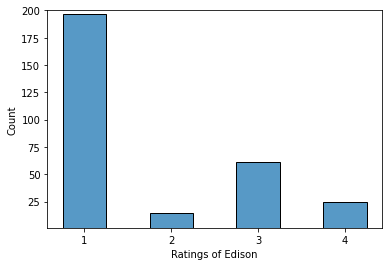

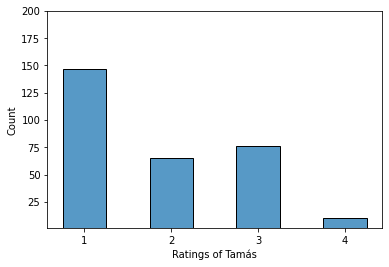

In [126]:
names = ['Edison', 'Tamás']

for idx, a in enumerate([labels_edison, labels_tamas]):
    g = seaborn.histplot(a, discrete=True, shrink=0.5)
    # This is so the x ticks are in integer, rather than double
    g.set_xticks([1, 2, 3, 4])
    g.set_ylim(1, 200)
    g.set_xlabel('Ratings of ' + names[idx])
    plt.show()

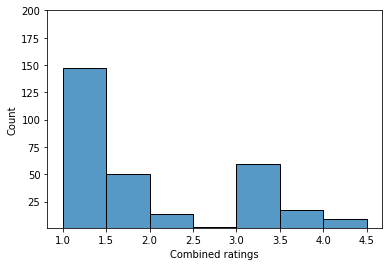

In [127]:
ax = seaborn.histplot(labels, bins=np.arange(1, 5, 0.5))
# Can't center bars around xtick value, smh
# The reason why it worked above is because
# of the discrete=True param
ax.set_xlabel('Combined ratings')
ax.set_ylim(1, 200)
plt.show()

Transforming image data to tensor arrays

In [128]:
images_tensor = np.ndarray(shape=(len(images_list), 50*50), dtype=np.float64)
for i in range(len(images_list)):
    img = Image.open(faces_path + images_list[i]).convert('L')
    images_tensor[i,:] = np.array(img, dtype='float64').flatten()

Computing the mean image

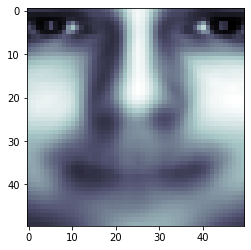

In [129]:
mean_face_flat = np.array([images_tensor[:,i].mean() for i in range (0, len(images_tensor[0,:]))])
mean_face = mean_face_flat.reshape(50, 50)
plt.imshow((mean_face).astype(np.float64), cmap=plt.cm.bone)
plt.show()

Subtract the mean from the image tensors

In [130]:
substracted_images_tensor = images_tensor - mean_face_flat

Top 10 scaled PCs

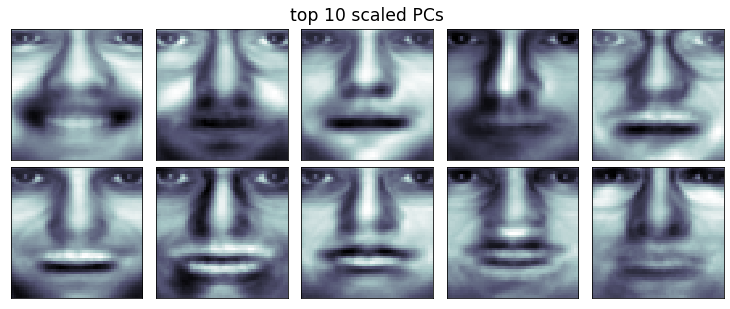

In [131]:
pca = PCA(0.95).fit(substracted_images_tensor)
minmax_scale = preprocessing.MinMaxScaler([0,255])

fig = plt.figure(figsize=(10, 10))
fig.suptitle('top 10 scaled PCs', fontsize = 'xx-large')
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.95, hspace=0.05, wspace=0.05)
fig.tight_layout()

for i in range(10): 
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    scaled_pc = minmax_scale.fit_transform(pca.components_[i,:].reshape(-1, 1))
    scaled_pc_and_mean = scaled_pc.T + mean_face.flatten()
    ax.imshow(np.reshape(scaled_pc_and_mean, (50,50)), cmap=plt.cm.bone, interpolation='nearest')

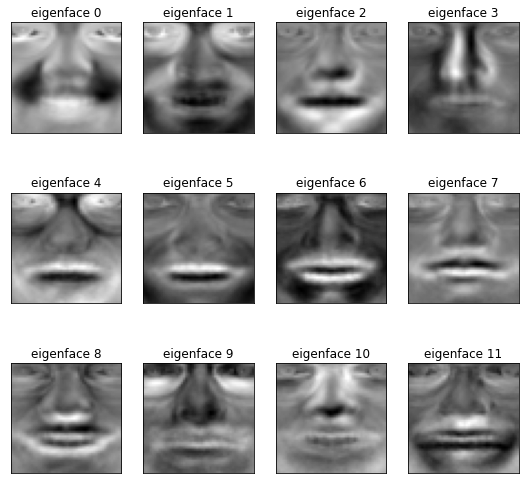

In [9]:
# # EIGENFACES (PURE PCs) NOT PART OF EXERCISE
# # https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html
# def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
#     """Helper function to plot a gallery of portraits"""
#     plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
#     plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
#     for i in range(n_row * n_col):
#         plt.subplot(n_row, n_col, i + 1)
#         eigenface_img = images[i].reshape((h, w)) + mean_face
#         plt.imshow(images[i].reshape((h, w)) + pca.mean_.reshape((h, w)), cmap=plt.cm.gray)
#         plt.title(titles[i], size=12)
#         plt.xticks(())
#         plt.yticks(())

# eigenfaces = pca.components_
# eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
# plot_gallery(eigenfaces, eigenface_titles, 50, 50)

Sequential feature selection (forward)

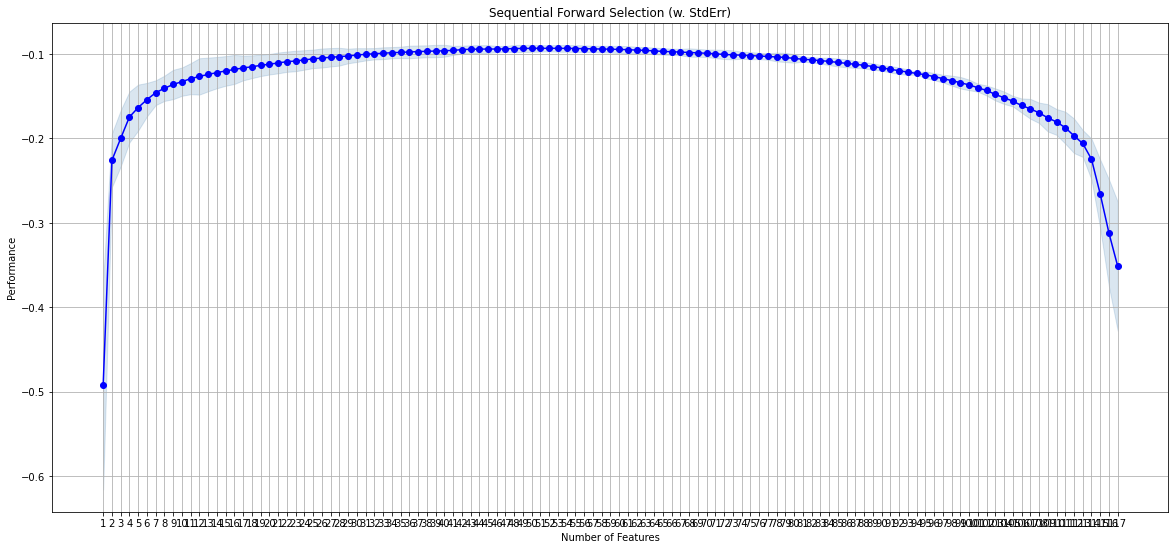

In [135]:
projected = pca.transform(substracted_images_tensor)

X = projected
y = labels
l_reg = LinearRegression()

# sequential forward selection
l_reg_model = SFS(l_reg,
          k_features=5, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=5)

fitting_sfs_model = l_reg_model.fit(X, y)

# plot model feature performance
fig = plot_sfs(l_reg_model.get_metric_dict(), kind='std_err', figsize=(20,9))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

Text(0.5, 1.0, 'Sequential Forward Selection (w. StdErr)')

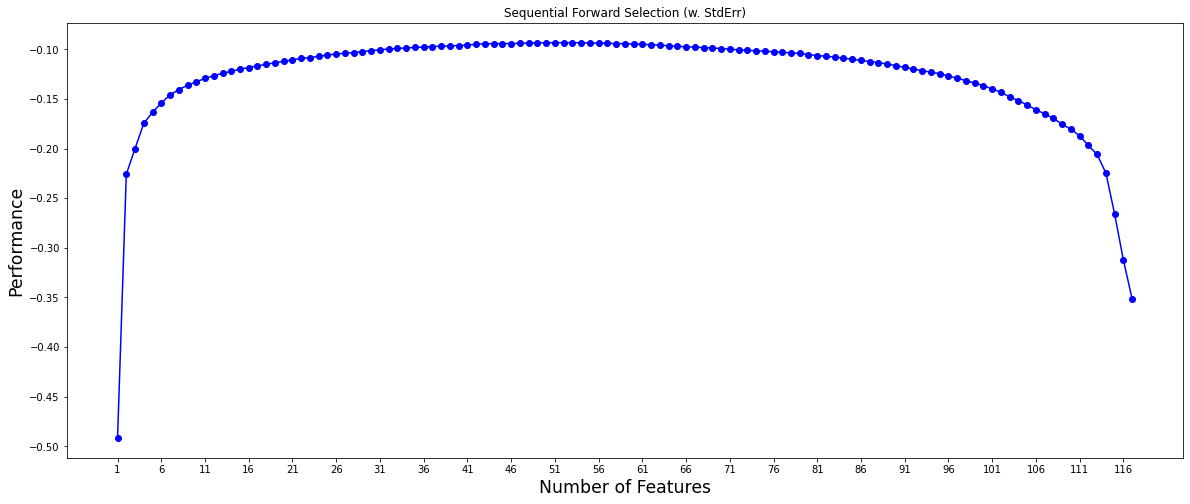

In [145]:
fig = plot_sequential_feature_selection(l_reg_model.get_metric_dict(), kind='std_err', figsize=(20,8))
plt.title('Sequential Forward Selection (w. StdErr)')

In [148]:
import matplotlib.pyplot as plt


def plot_sequential_feature_selection(metric_dict,
                                      figsize=None,
                                      kind='std_dev',
                                      color='blue',
                                      bcolor='steelblue',
                                      marker='o',
                                      alpha=0.2,
                                      ylabel='Performance',
                                      confidence_interval=0.95):


    allowed = {'std_dev', 'std_err', 'ci', None}
    if kind not in allowed:
        raise AttributeError('kind not in %s' % allowed)

    # fig = plt.figure()
    if figsize is not None:
        fig = plt.subplots(figsize=figsize)
    else:
        fig = plt.subplots()

    k_feat = sorted(metric_dict.keys())
    avg = [metric_dict[k]['avg_score'] for k in k_feat]

    if kind:
        upper, lower = [], []
        if kind == 'ci':
            kind = 'ci_bound'

        for k in k_feat:
            upper.append(metric_dict[k]['avg_score'] +
                         metric_dict[k][kind])
            lower.append(metric_dict[k]['avg_score'] -
                         metric_dict[k][kind])

        # plt.fill_between(k_feat,
        #                  upper,
        #                  lower,
        #                  alpha=alpha,
        #                  color=bcolor,
        #                  lw=1)

        if kind == 'ci_bound':
            kind = 'Confidence Interval (%d%%)' % (confidence_interval * 100)

    plt.plot(k_feat, avg, color=color, marker=marker)
    plt.ylabel(ylabel, fontsize='xx-large')
    plt.xlabel('Number of Features', fontsize='xx-large')
    feature_min = len(metric_dict[k_feat[0]]['feature_idx'])
    feature_max = len(metric_dict[k_feat[-1]]['feature_idx'])
    plt.xticks(range(feature_min, feature_max + 1, 5),
               range(feature_min, feature_max + 1, 5))

    return fig

In [121]:
# To check the picked features
l_reg_model.subsets_

{1: {'feature_idx': (0,),
  'cv_scores': array([-0.93637286, -0.40106742, -0.29985451, -0.24994767, -0.57126995]),
  'avg_score': -0.49170248077451345,
  'feature_names': ('0',)},
 2: {'feature_idx': (0, 1),
  'cv_scores': array([-0.2652636 , -0.22231608, -0.1801888 , -0.1399849 , -0.32157483]),
  'avg_score': -0.22586564161644707,
  'feature_names': ('0', '1')},
 3: {'feature_idx': (0, 1, 12),
  'cv_scores': array([-0.23448297, -0.19088172, -0.13337314, -0.13248843, -0.30856101]),
  'avg_score': -0.1999574536055027,
  'feature_names': ('0', '1', '12')},
 4: {'feature_idx': (0, 1, 2, 12),
  'cv_scores': array([-0.24235676, -0.14288613, -0.13131459, -0.10551826, -0.25097325]),
  'avg_score': -0.1746097961432835,
  'feature_names': ('0', '1', '2', '12')},
 5: {'feature_idx': (0, 1, 2, 12, 16),
  'cv_scores': array([-0.22560905, -0.14572548, -0.10332062, -0.11265347, -0.22990907]),
  'avg_score': -0.16344353993812583,
  'feature_names': ('0', '1', '2', '12', '16')}}

Fit the model with optimal features

In [66]:
feature_idxs_that_optimize_regression_model = l_reg_model.k_feature_idx_
projected_optimized = projected[: , feature_idxs_that_optimize_regression_model]
l_reg_optimized = LinearRegression()
l_reg_optimized.fit(projected_optimized, y)

LinearRegression()

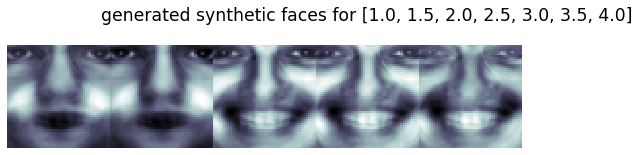

In [152]:
y_list = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]

fig = plt.figure(figsize=(10, 10))
fig.suptitle('generated synthetic faces for [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]', fontsize = 'xx-large')
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.95, hspace=0.0, wspace=0.0)
fig.tight_layout()

for i in range(len(y_list)):
    ax = fig.add_subplot(5, 7, i+1, xticks=[], yticks=[])
    ax.axis('off')
    y0 = y_list[i]
    slope = l_reg_optimized.coef_
    alpha = (y0 - l_reg_optimized.intercept_)/(slope.T@slope)
    predicted_image = alpha * slope

    # synthetic_image = l_reg_model.inverse_transform(predicted_image.reshape(1, -1))
    # synthetic_image = pca.inverse_transform(synthetic_image.reshape(1, -1))
    
    # inverse projection into original space
    predicted_image_r = predicted_image.T.reshape(1, len(feature_idxs_that_optimize_regression_model))
    synthetic_image = np.dot(predicted_image_r, pca.components_[feature_idxs_that_optimize_regression_model, :])
    ax.imshow(np.reshape(synthetic_image, (50,50)) + mean_face, cmap=plt.cm.bone, interpolation='nearest')
    to_save = Image.fromarray(np.reshape(synthetic_image, (50,50)) + mean_face)
    to_save.convert('RGB').save(str(i) + '.png')

# 2nd experiment - Create ROc curves for baseline - and all other stimulis - compute the values of the ROC curves - say something about

In [47]:
#TODO